## BiLSTM_keras_model

### This notebook is for the reference of the model used in Insight_Worker

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

Long Short Term Memory(LSTM) seems to be among the best algorithms to use for stock price prediction, weather forecasting, text prediction ,anomaly detection etc.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!




In [100]:
import tensorflow as tf
import pandas as pd
import requests
import datetime
import json
import numpy as np
import seaborn as sns
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,load_model
#from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.ensemble import IsolationForest
from tensorflow.keras.layers import Dense,Activation,Bidirectional
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

import pickle
from joblib import dump, load

In [2]:
import os
def read_config(section, name=None, environment_variable=None, default=None, config_file_path='../../augur.config.json', no_config_file=0, use_main_config=0):
    """
    Read a variable in specified section of the config file, unless provided an environment variable

    :param section: location of given variable
    :param name: name of variable
    """
    _config_file_name = 'augur.config.json'
    _config_bad = False
    _already_exported = {}
    _runtime_location = 'runtime/'
    _default_config = {}
    _config_file = None

    try:
        _config_file = open(config_file_path, 'r+')
    except:
        print('Couldn\'t open {}'.format(_config_file_name))

    # Load the config file
    try:
        config_text = _config_file.read()
        _config = json.loads(config_text)
    except json.decoder.JSONDecodeError as e:
        if not _config_bad:
            _using_config_file = False
            print('{} could not be parsed, using defaults. Fix that file, or delete it and run this again to regenerate it. Error: {}'.format(config_file_path, str(e)))
        _config = _default_config

    value = None
    if environment_variable is not None:
        value = os.getenv(environment_variable)
    if value is None:
        try:
            if name is not None:
                value = _config[section][name]
            else:
                value = _config[section]
        except Exception as e:
            value = default
            if not section in _config:
                _config[section] = {}

    return value

In [3]:
augur_api_host = read_config("Server", "host", "AUGUR_HOST", "0.0.0.0",config_file_path='/Users/pratikmishra/augur/augur.config.json')
augur_api_port = read_config("Server", "port", "AUGUR_PORT", 5000,config_file_path='/Users/pratikmishra/augur/augur.config.json')

time_series = ['code-changes-lines','issues-new','reviews']
              
def time_series_metrics(repo_id):
    training_days = 365
    
    base_url = 'http://{}:{}/api/unstable/repo-groups/20/repos/{}/'.format(augur_api_host,augur_api_port,repo_id)
    begin_date = datetime.datetime(2019, 3, 31, 0, 0)#datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - datetime.timedelta(days=training_days)
    index = pd.date_range(begin_date, periods=training_days, freq='D')
    df = pd.DataFrame(index)
    df.columns = ['date']
    df['date'] = df['date'].astype(str)

    for endpoint in time_series:
        #print(endpoint)
        
        url = base_url + endpoint
        print("Hitting endpoint: " + url + "\n")
        try:
            data = requests.get(url=url).json()
            #print(data)
        except:
            data = json.loads(json.dumps(requests.get(url=url).text))

        if len(data) == 0:
            print("Endpoint with url: {} returned an empty response. Moving on to next endpoint.\n".format(url))
            continue
                    
        if 'date' not in data[0]:
            print("Endpoint {} is not a timeseries, moving to next endpoint.\n".format(endpoint))
            continue
                
        metric_df = pd.DataFrame.from_records(data)
        metric_df['date'] = pd.to_datetime(metric_df['date']).dt.date
        metric_df['date'] = metric_df['date'].astype(str)
        extra=['repo','rg','week','year']
        for column in metric_df.columns:
            if any(x in column for x in extra):
                metric_df.drop(column,axis=1,inplace=True)
                
        df = pd.DataFrame(pd.merge(df,metric_df.loc[:,metric_df.columns],how = 'left',on = 'date'))
        metric_df.drop('date',axis=1,inplace=True)
        df.rename(columns={i :"{} _ {}".format(endpoint, i) for i in metric_df.columns }, inplace=True)
    return df

### Optimal LSTM model configuration to perform well over all types of data

In [4]:

def preprocess_data(data,tr_days,lback_days,n_features,n_predays):
    
    train_data = data.values

    features_set = []
    labels = []
    for i in range(lback_days, tr_days+1):
        features_set.append(train_data[i-lback_days:i,0])
        labels.append(train_data[i:i+n_predays, 0])

    features_set = np.array(features_set)
    labels = np.array(labels)

    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], n_features))

    
    return features_set,labels


def model_lstm(features_set,n_predays,n_features):
    model = Sequential()
    model.add(Bidirectional(LSTM(90, activation='linear',return_sequences=True, input_shape=(features_set.shape[1], n_features))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(90, activation='linear',return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(90, activation='linear')))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(optimizer='adam', loss='mae')
    return model

In [92]:
def lstm_keras(repo_id,df,window_size):
            
            
    scaler = StandardScaler()
    
    
    data = pd.DataFrame(df.iloc[:,1])
    data = pd.DataFrame(scaler.fit_transform(data.values))
    


    #tr_days : number of training days
    #lback_days : number of days to lookback for next prediction
    #n_features : number of features of columns in dataframe for training
    #n_predays : next number of days to predict


    lback_days = window_size
    tr_days = 365 -lback_days
    n_features = 1
    n_predays = 1
    
    # calling preprocessing method to arrange data in the required input and output shape
    features_set,labels = preprocess_data(data,tr_days,lback_days,n_features,n_predays)
    model = model_lstm(features_set,n_predays,n_features)

    #fitting model
    history = model.fit(features_set, labels, epochs = 50, batch_size = lback_days,validation_split=0.1,verbose=0).history


    # arranging test data in the required input shape
    test_inputs = data[ :len(df.iloc[:,1])].values
    test_inputs = test_inputs.reshape(-1,n_features)
    test_features = []
    for i in range(lback_days, len(df.iloc[:,1])):
        test_features.append(test_inputs[i-lback_days:i, 0])

    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], n_features))
    predictions = model.predict(test_features)
    predictions = scaler.inverse_transform(predictions)

    
    #Calculating error
    #scroe is the differene between the actual value and predicted value
    #model predict the value over the whole training days execpt the very first set of time_step
    # prediction value for the very first set of time step is the mean of the actual value in that time_step
    
    test_data = df.iloc[lback_days:,1]
    error = np.array(test_data[:]- predictions[:,0])            
    df['score'] = 0
    df.iloc[:lback_days,2] = df.iloc[:lback_days,1] - np.mean(df.iloc[:lback_days,1])
    df.iloc[lback_days:,2] = error

    # Classifying outliers
    #initialising anomaly_class columns, 
    df['anomaly_class'] = 0
    filt = df.iloc[:lback_days,2]>2*np.mean(abs(df.iloc[:lback_days,2]))
    df.iloc[:lback_days,:].loc[filt,'anomaly_class']=1

    # Classifying global outliers with value 2
    #score exceeding the mean_3* std of the total score value 
    #for the whole training days are considered as global outliers
    
    mean = np.mean(abs(df.iloc[:,2]))
    std_error = np.std(abs(df.iloc[:,2]))
    filt = (df.iloc[:,2]>3*std_error + mean) | (df.iloc[:,2]<-3*std_error - mean)
    df.iloc[:,3][filt] = 2


    # Classifying local outliers with value 1 using std and mean
    #calculating threshold value based on gicen contamination_factor and std,mean of the normal score values.
    for i in range(lback_days,len(df)):

        filt = df.iloc[i-lback_days:i,3]!=2
        std_error = np.std(abs(df.iloc[i-lback_days:i,2][filt]))
        mean = np.mean(abs(df.iloc[i-lback_days:i,2][filt]))
        threshold = mean + (3*(std_error)*(1-2*0.1))    # 0.1 is contamination factor

        if ((df.iloc[i,2] > threshold) | (df.iloc[i,2] < -threshold)):
            if(df.iloc[i,3]!=2):
                df.iloc[i,3]=1
   

    return df
    

In [7]:
#fetching the data using Augur's APs 

repo_id = 25663
dfd = time_series_metrics(repo_id)

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/code-changes-lines

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/issues-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/reviews



In [13]:
dfd = dfd.fillna(0)
dfd.head()

,date,code-changes-lines _ added,code-changes-lines _ removed,issues-new _ issues,reviews _ pull_requests
0,2019-03-31,393.0,147.0,7.0,0.0
1,2019-04-01,1109.0,647.0,4.0,2.0
2,2019-04-02,707.0,503.0,5.0,1.0
3,2019-04-03,1800.0,576.0,6.0,0.0
4,2019-04-04,793.0,409.0,13.0,1.0


In [93]:
#code for calculating the time_step or window_size and batch_size for the BiLSTM model
#window_size is equal to batch size
#window_size is calculated considering sparsity in the data and the coefficient of variation in the data
# i is the index value of column in dfd dataframe
i=3
ddt = dfd.iloc[:,i][ (dfd.iloc[:,i]<np.percentile(dfd.iloc[:,i], 90))]
ddt.dropna(axis=0,inplace=True)

window_size=0
if np.isnan(np.std(ddt)) or np.isnan(np.mean(ddt)) or np.mean(ddt)<0.01 or np.std(ddt)<0.01:
    window_size = 3

else: 
    # parameters defined in a way such that window size varies between 3-36 for better results
    param = int(365/36)
    non_zero_day = 365 - np.sum(dfd.iloc[:,i]==0)
    window_size = int( (non_zero_day/param) - 3*(np.std(ddt)/np.mean(ddt)) )


if window_size<3:
    window_size = 3


In [94]:
df_summary = lstm_keras(repo_id,pd.DataFrame(dfd.iloc[:,[0,i]]),window_size)

/Users/pratikmishra/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/pratikmishra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [95]:
df_summary.head()

,date,issues-new _ issues,score,anomaly_class
0,2019-03-31,7.0,3.193548,0
1,2019-04-01,4.0,0.193548,0
2,2019-04-02,5.0,1.193548,0
3,2019-04-03,6.0,2.193548,0
4,2019-04-04,13.0,9.193548,2


In [96]:
df_summary['predictions'] = df_summary.iloc[:,1] - df_summary.iloc[:,2]

In [97]:
df_summary.tail()

,date,issues-new _ issues,score,anomaly_class,predictions
360,2020-03-25,6.0,-0.498099,0,6.498099
361,2020-03-26,3.0,-3.197937,0,6.197937
362,2020-03-27,0.0,-4.816881,0,4.816881
363,2020-03-28,5.0,1.131142,0,3.868858
364,2020-03-29,5.0,1.174575,0,3.825425


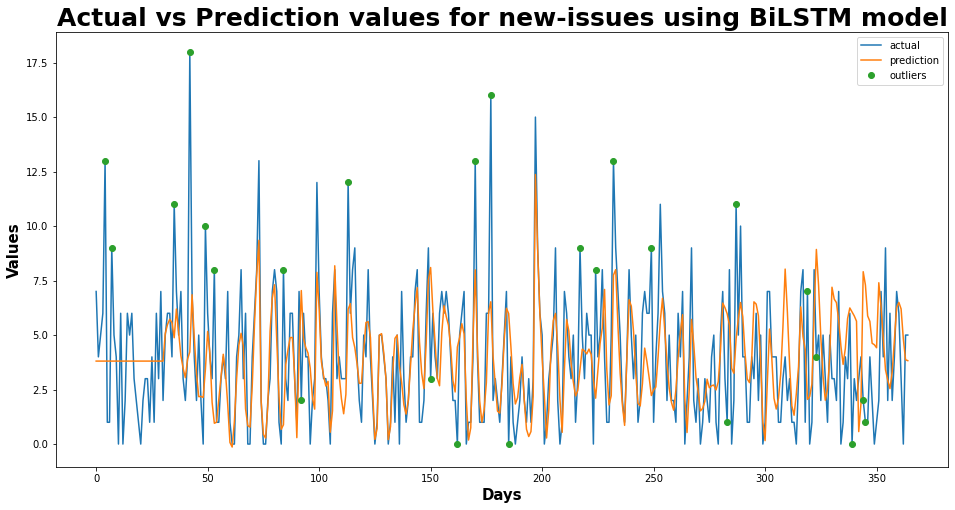

In [102]:
plt.figure(figsize=(16,8))

filt = df_summary.iloc[:,3]!=0
plt.plot(df_summary.iloc[:,1],label='actual')
plt.plot(df_summary.iloc[:,4],label='prediction')
plt.plot(df_summary.iloc[:,1][filt],'o',label='outliers')

plt.title('Actual vs Prediction values for new-issues using BiLSTM model',fontsize=25, fontweight='bold')
plt.xlabel('Days', fontsize=15, fontweight='bold')
plt.ylabel('Values', fontsize=15, fontweight='bold')  

plt.legend()

#line with constant value in the plot is due to the very first set of time_step.

### IsolationForest model

In [83]:
from sklearn.ensemble import IsolationForest


model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.08), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=32, verbose=0)

model.fit(dfd.iloc[:,3].values.reshape(-1,1))
pred = model.predict(dfd.iloc[:,3].values.reshape(-1,1))

# Create df and adopt previous index from when we called the endpoints
anomaly_df = pd.DataFrame()
anomaly_df['date_col'] = dfd.date
anomaly_df.index = dfd.index

# Find decision function to find the score and classify anomalies
anomaly_df['score'] = model.decision_function(dfd.iloc[:,3].values.reshape(-1,1))
anomaly_df['issues'] = dfd.iloc[:,3].values
anomaly_df['anomaly_class'] = pred

# Get the indexes of outliers in order to compare the metrics with use case anomalies if required
outliers = anomaly_df.loc[anomaly_df['anomaly_class'] == -1]
outlier_index = list(outliers.index)
#anomaly_df = classify_anomalies(anomaly_df,'issues')

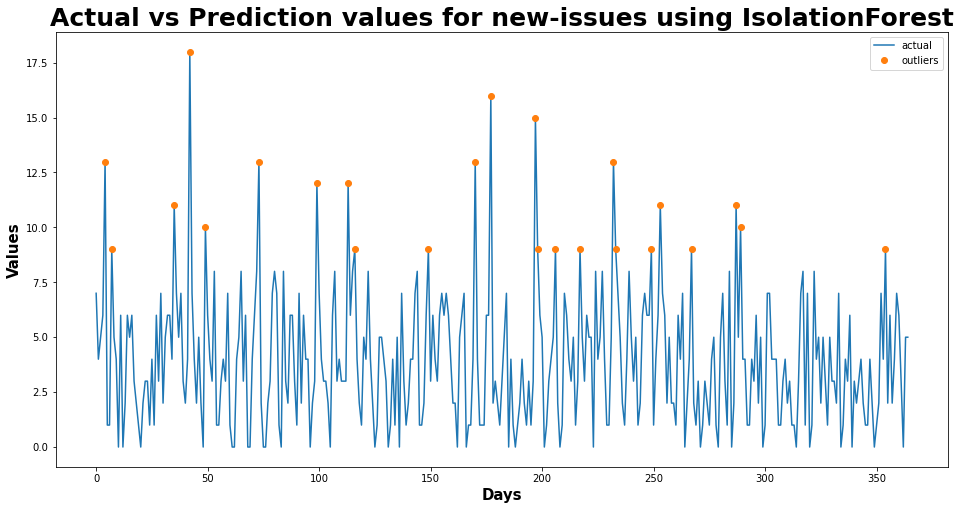

In [103]:
filt = anomaly_df.iloc[:,3] !=1
plt.figure(figsize=(16,8))
plt.plot(anomaly_df.iloc[:,2],label='actual')
plt.plot(anomaly_df.iloc[:,2][filt],'o',label='outliers')

plt.title('Actual vs Prediction values for new-issues using IsolationForest',fontsize=25, fontweight='bold')
plt.xlabel('Days', fontsize=15, fontweight='bold')
plt.ylabel('Values', fontsize=15, fontweight='bold') 

plt.legend()

## Comparative analysis of classification result between BiLSTM and IsolaForest models

These two models are being performed on on 30 different datasets with different metrics.In this dataframe we stored the different parameters like contaminaton_factor , score and elements of confusion metrics.
* Score for the IsolationForest model is the mean of values from decision_fcuntion
* Score for the BiLSTM model is the ratio of the error in the prediction and the actual value
* TP,FP,TN,FN are calculated using analysis of the value manually, so the definition of outliers may be different for difeerent users

In [53]:
df_analysis = pd.read_csv("comparative_analysis.csv")

In [69]:
df_analysis

,repo_id,metric,field,model,contamination_factor,score,True_positive,False_positive,True_negative,False_negative
0,3422,issues-new,issues,BiLSTM,0.090411,0.248484,17,2,341,3
1,3422,issues-new,issues,IsolationForest,0.087671,0.064410,15,5,342,3
2,1787,issues-new,issues,BiLSTM,0.052055,0.379024,13,6,343,4
3,1787,issues-new,issues,IsolationForest,0.071233,0.036162,11,14,336,4
4,209,issues-new,issues,BiLSTM,0.095890,0.487231,25,8,329,3
5,209,issues-new,issues,IsolationForest,0.101370,0.102912,22,18,315,10
6,1622,issues-new,issues,BiLSTM,0.068493,0.301766,15,10,337,3
7,1622,issues-new,issues,IsolationForest,0.098630,0.142178,17,19,328,11
8,6061,issues-new,issues,BiLSTM,0.054795,0.446143,15,5,340,5
9,6061,issues-new,issues,IsolationForest,0.087671,0.119980,18,7,337,3


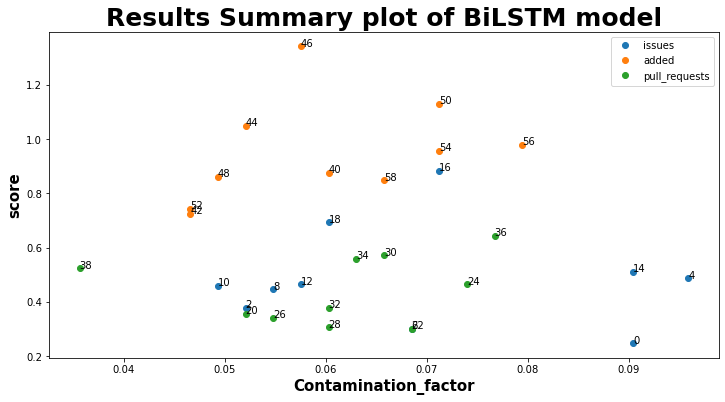

In [105]:
fig, ax = plt.subplots(figsize=(12,6))
filt_issues = ((df_analysis['field']=='issues') & (df_analysis['model']=='BiLSTM'))
filt_added = ((df_analysis['field']=='added') & (df_analysis['model']=='BiLSTM'))
filt_pull_requests = ((df_analysis['field']=='pull_requests') & (df_analysis['model']=='BiLSTM'))

x = df_analysis.iloc[:,4][filt_issues].values
y = df_analysis.iloc[:,5][filt_issues].values
ax.plot(df_analysis.iloc[:,4][filt_issues],df_analysis.iloc[:,5][filt_issues],'o',label='issues')
n = df_analysis.iloc[:,4][filt_issues].index
for i,txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
    

x = df_analysis.iloc[:,4][filt_added].values
y = df_analysis.iloc[:,5][filt_added].values
ax.plot(df_analysis.iloc[:,4][filt_added],df_analysis.iloc[:,5][filt_added],'o',label='added')
n = df_analysis.iloc[:,4][filt_added].index
for i,txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
               
               
x = df_analysis.iloc[:,4][filt_pull_requests].values
y = df_analysis.iloc[:,5][filt_pull_requests].values               
ax.plot(df_analysis.iloc[:,4][filt_pull_requests],df_analysis.iloc[:,5][filt_pull_requests],'o',label='pull_requests')
n = df_analysis.iloc[:,4][filt_pull_requests].index
for i,txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
    
plt.title('Results Summary plot of BiLSTM model',fontsize=25, fontweight='bold')
plt.xlabel('Contamination_factor', fontsize=15, fontweight='bold')
plt.ylabel('score', fontsize=15, fontweight='bold')    
plt.legend()

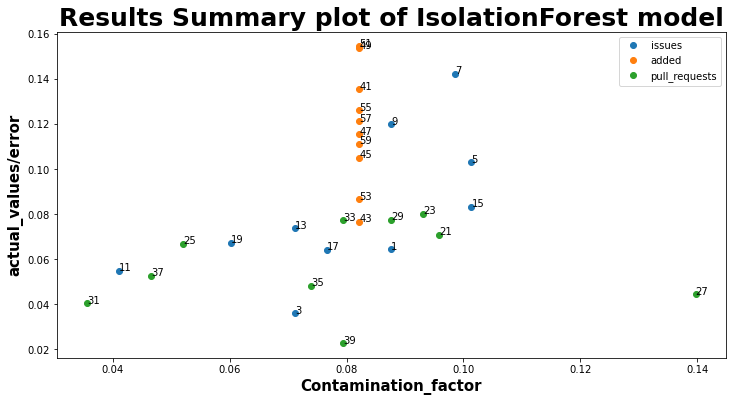

In [106]:
fig, ax = plt.subplots(figsize=(12,6))
filt_issues = ((df_analysis['field']=='issues') & (df_analysis['model']=='IsolationForest'))
filt_added = ((df_analysis['field']=='added') & (df_analysis['model']=='IsolationForest'))
#filt_removed = df_analysis['field']=='removed'
filt_pull_requests = ((df_analysis['field']=='pull_requests') & (df_analysis['model']=='IsolationForest'))

x = df_analysis.iloc[:,4][filt_issues].values
y = df_analysis.iloc[:,5][filt_issues].values
ax.plot(df_analysis.iloc[:,4][filt_issues],df_analysis.iloc[:,5][filt_issues],'o',label='issues')
n = df_analysis.iloc[:,4][filt_issues].index
for i,txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
    

x = df_analysis.iloc[:,4][filt_added].values
y = df_analysis.iloc[:,5][filt_added].values
ax.plot(df_analysis.iloc[:,4][filt_added],df_analysis.iloc[:,5][filt_added],'o',label='added')
n = df_analysis.iloc[:,4][filt_added].index
for i,txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
    
               
x = df_analysis.iloc[:,4][filt_pull_requests].values
y = df_analysis.iloc[:,5][filt_pull_requests].values               
ax.plot(df_analysis.iloc[:,4][filt_pull_requests],df_analysis.iloc[:,5][filt_pull_requests],'o',label='pull_requests')
n = df_analysis.iloc[:,4][filt_pull_requests].index
for i,txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
    
plt.title('Results Summary plot of IsolationForest model',fontsize=25, fontweight='bold')
plt.xlabel('Contamination_factor', fontsize=15, fontweight='bold')
plt.ylabel('actual_values/error', fontsize=15, fontweight='bold')    
plt.legend()

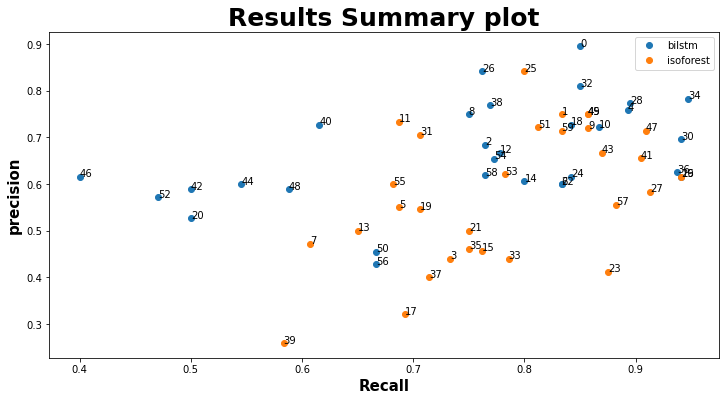

In [107]:
fig, ax = plt.subplots(figsize=(12,6))
filt_bilstm =  (df_analysis['model']=='BiLSTM')
filt_isoforest = (df_analysis['model']=='IsolationForest')


x = df_analysis.iloc[:,6][filt_bilstm].values/(df_analysis.iloc[:,6][filt_bilstm].values + df_analysis.iloc[:,9][filt_bilstm].values)
y = df_analysis.iloc[:,6][filt_bilstm].values/(df_analysis.iloc[:,6][filt_bilstm].values + df_analysis.iloc[:,7][filt_bilstm].values)
ax.plot(x,y,'o',label='bilstm')
n = df_analysis.iloc[:,6][filt_bilstm].index
for i,txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
    

x = df_analysis.iloc[:,6][filt_isoforest].values/(df_analysis.iloc[:,6][filt_isoforest].values + df_analysis.iloc[:,9][filt_isoforest].values)
y = df_analysis.iloc[:,6][filt_isoforest].values/(df_analysis.iloc[:,6][filt_isoforest].values + df_analysis.iloc[:,7][filt_isoforest].values)
ax.plot(x,y,'o',label='isoforest')
n = df_analysis.iloc[:,6][filt_isoforest].index
for i,txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
    

    
plt.title('Results Summary plot',fontsize=25, fontweight='bold')
plt.xlabel('Recall', fontsize=15, fontweight='bold')
plt.ylabel('precision', fontsize=15, fontweight='bold')    
plt.legend()

## Observations

* IsolationForest fails in detecting the sequence in the data.
* IsolationForest only classifies the extreme values as outliers, while BiLSTM model claasify outliers based on sequence.
* In BiLSTM score for the code-changes-lines metrics is high, which suggests that model struggles in the predicting the sequence for that metrics.This is because the data in code-changes-lines metrics have a wide range of values which makes it difficult to standarise the data.
* Precision and Recall of BiSLTM model is impressive except the code-changes-lines metrics results.
* Precision and Rrecall of IsolationForest model is also good in nearly half of the cases.
* Parameters in the BiLSTM model automatically changes accroding to the data which makes it situable for all types of data.
* Some sort of improvements needed for code-changes-lines-metrics,otherwise BiLSTM can be used for almost every time_series metrics